In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
data = pd.read_csv("/content/drive/MyDrive/mnist_train_unzipped/mnist_train.csv")

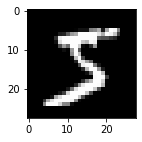

Lable: 5


In [28]:
# Display or plot an image
def display_image(idx):
  plt.figure(figsize=(2,2))
  labels = data["label"]
  data_drop_label = data.drop(["label"], axis=1)
  grid_data = data_drop_label.iloc[idx].to_numpy().reshape(28,28)  # reshape from 1d to 2d pixel array
  plt.imshow(grid_data, interpolation = "none", cmap = "gray")
  plt.show()

  print("Lable:", labels[idx])

display_image(0)

In [30]:
train_df, test_df = train_test_split(data, test_size=0.2)  #Split data into train and test.
train_labels = train_df["label"]
test_labels =test_df["label"]
train_data = train_df.drop("label",axis=1)
test_data = test_df.drop("label", axis=1)
train_data = np.array(train_data.T)/255.
test_data = np.array(test_data.T)/255.      #Normalize the data.
n, m = train_data.shape

In [31]:
def init_params(): #Initialize Parameters.
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5 
    b2 = np.random.rand(10, 1) - 0.5
    W3 = np.random.rand(10, 10) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    k0 = np.random.rand(1)
    k1 = np.random.rand(1)
    return W1, b1, W2, b2, W3, b3, k0, k1 

def activaton(Z, k0, k1):  #Define activation function.
    return k0 +(k1*Z)

def softmax(Z):            #Define softmax function
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, W3, b3, k0, k1, X):   #Define forward propagation.
    Z1 = W1.dot(X) + b1
    A1 = activaton(Z1, k0, k1)
    Z2 = W2.dot(A1) + b2
    A2 = activaton(Z2, k0, k1)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

def actva_deri(Z, k0, k1):     #Derivative of activation function.
    return k1

def one_hot(Y):                #One hot encoding for labels.
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, k0, k1, X, Y):    #define backward propagation.
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    dA2 = W3.T.dot(dZ3)
    dZ2 = W3.T.dot(dZ3) * actva_deri(Z2, k0, k1)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dA1 = W2.T.dot(dZ2)
    dZ1 = W2.T.dot(dZ2) * actva_deri(Z1, k0, k1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    dk0 = np.average(dA1)
    dk1 = np.average(dA1*Z1)
    return dW1, db1, dW2, db2, dW3, db3, dk0, dk1

def update_params(W1, b1, W2, b2, W3, b3, k0, k1, dW1, db1, dW2, db2, dW3, db3, dk0, dk1, alpha):    #Update parameters.
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3  
    b3 = b3 - alpha * db3
    k0 = k0 - alpha * dk0
    k1 = k1 - alpha * dk1    
    return W1, b1, W2, b2, W3, b3, k0, k1

In [32]:
def loss_crossentropy(probas, y):          #Categorical cross entopy loss function.
  tanspose_probas = probas.T
  transpose_y = y.T
  training_point_loss = []
  for list_1, list_2 in zip(tanspose_probas, transpose_y):
    for i, j in zip(list_1, list_2):
      training_point_loss.append(np.sum(np.log(i)*(-j)))
  total_loss = np.mean(training_point_loss)
  return total_loss

def get_predictions(A3):                   #make Predictions
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):          #Define accuracy
    return np.sum(predictions == Y) / Y.size

def Test_loss_accuracy(X, W1, b1, W2, b2, W3, b3, k0, k1):     #loss-accuracy calculation for test data.
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, k0, k1, X)
    Test_loss = loss_crossentropy(A3, one_hot(test_labels))
    Test_accuracy = get_accuracy(get_predictions(A3), test_labels)
    return Test_loss, Test_accuracy    

In [33]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3, k0, k1 = init_params()
    Train_loss_lst, Train_accuracy_lst, Test_loss_lst, Test_accuracy_lst, k0_lst, k1_lst = [], [], [], [], [], []
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, k0, k1, X)
        dW1, db1, dW2, db2, dW3, db3, dk0, dk1 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, k0, k1, X, Y)
        W1, b1, W2, b2, W3, b3, k0, k1 = update_params(W1, b1, W2, b2, W3, b3, k0, k1, dW1, db1, dW2, db2, dW3, db3, dk0, dk1,alpha)
        if i % 10 == 0:
          print("\033[1m" + "Iteration" + "\033[0m", i)
          total_loss = loss_crossentropy(A3, one_hot(Y))
          Train_accuracy = get_accuracy(get_predictions(A3), Y)
          Test_loss, Test_accuracy = Test_loss_accuracy(test_data, W1, b1, W2, b2, W3, b3, k0, k1)
          Train_loss_lst.append(total_loss), Train_accuracy_lst.append(Train_accuracy), Test_loss_lst.append(Test_loss), Test_accuracy_lst.append(Test_accuracy)
          k0_lst.append(k0)
          k1_lst.append(k1)
          print("k0 and k1:", k0, k1)
    return W1, b1, W2, b2, W3, b3, k0, k1, Train_loss_lst, Train_accuracy_lst, Test_loss_lst, Test_accuracy_lst, k0_lst, k1_lst 

#### **Model training.**

In [34]:
W1, b1, W2, b2, W3, b3, k0, k1, Train_loss_lst, Train_accuracy_lst, Test_loss_lst, Test_accuracy_lst, k0_lst, k1_lst = gradient_descent(train_data, train_labels, 0.10, 500)

Iteration 0
k0 and k1: [0.39164288] [0.23408116]
Iteration 10
k0 and k1: [0.38721934] [0.23180426]
Iteration 20
k0 and k1: [0.38409459] [0.23161396]
Iteration 30
k0 and k1: [0.38179041] [0.23314798]
Iteration 40
k0 and k1: [0.38003509] [0.23629931]
Iteration 50
k0 and k1: [0.3786555] [0.24109778]
Iteration 60
k0 and k1: [0.37753199] [0.24767541]
Iteration 70
k0 and k1: [0.3765768] [0.25626442]
Iteration 80
k0 and k1: [0.37572243] [0.26721361]
Iteration 90
k0 and k1: [0.37491489] [0.28102018]
Iteration 100
k0 and k1: [0.37410967] [0.29837795]
Iteration 110
k0 and k1: [0.37326997] [0.3202409]
Iteration 120
k0 and k1: [0.37236785] [0.34788448]
Iteration 130
k0 and k1: [0.37138947] [0.38287981]
Iteration 140
k0 and k1: [0.37034327] [0.42668277]
Iteration 150
k0 and k1: [0.36925816] [0.47911972]
Iteration 160
k0 and k1: [0.36817559] [0.5356726]
Iteration 170
k0 and k1: [0.36730295] [0.58857256]
Iteration 180
k0 and k1: [0.36694878] [0.63366597]
Iteration 190
k0 and k1: [0.36699522] [0.67016

#### **Train_vs_Test Loss and Train_vs_Test Accuracy.**

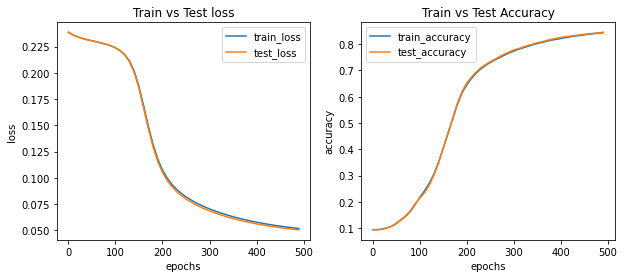

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
epochs = list(range(0,500, 10))
sns.lineplot(epochs,Train_loss_lst,label='train_loss', ax=ax1)
sns.lineplot(epochs,Test_loss_lst,label='test_loss', ax=ax1)
sns.lineplot(epochs,Train_accuracy_lst,label='train_accuracy', ax=ax2)
sns.lineplot(epochs,Test_accuracy_lst,label='test_accuracy', ax=ax2)
ax1.set(xlabel="epochs", ylabel="loss")
ax2.set(xlabel="epochs", ylabel="accuracy")
ax1.title.set_text("Train vs Test loss")
ax2.title.set_text("Train vs Test Accuracy")
plt.show()

In [36]:
print(k1_lst)

[array([0.23408116]), array([0.23180426]), array([0.23161396]), array([0.23314798]), array([0.23629931]), array([0.24109778]), array([0.24767541]), array([0.25626442]), array([0.26721361]), array([0.28102018]), array([0.29837795]), array([0.3202409]), array([0.34788448]), array([0.38287981]), array([0.42668277]), array([0.47911972]), array([0.5356726]), array([0.58857256]), array([0.63366597]), array([0.67016414]), array([0.69841218]), array([0.71980194]), array([0.73602477]), array([0.74852282]), array([0.75837119]), array([0.76633125]), array([0.77293274]), array([0.77854237]), array([0.78341388]), array([0.7877233]), array([0.79159314]), array([0.79510905]), array([0.7983312]), array([0.80130208]), array([0.80405194]), array([0.80660263]), array([0.80897029]), array([0.8111673]), array([0.81320362]), array([0.81508782]), array([0.81682766]), array([0.81843056]), array([0.81990389]), array([0.82125501]), array([0.82249142]), array([0.82362066]), array([0.82465029]), array([0.82558781

In [37]:
print(k0_lst)

[array([0.39164288]), array([0.38721934]), array([0.38409459]), array([0.38179041]), array([0.38003509]), array([0.3786555]), array([0.37753199]), array([0.3765768]), array([0.37572243]), array([0.37491489]), array([0.37410967]), array([0.37326997]), array([0.37236785]), array([0.37138947]), array([0.37034327]), array([0.36925816]), array([0.36817559]), array([0.36730295]), array([0.36694878]), array([0.36699522]), array([0.36705568]), array([0.36695185]), array([0.36671861]), array([0.36641766]), array([0.366088]), array([0.3657503]), array([0.3654148]), array([0.36508644]), array([0.3647676]), array([0.36445954]), array([0.3641631]), array([0.36387892]), array([0.36360754]), array([0.36334939]), array([0.36310478]), array([0.36287384]), array([0.36265658]), array([0.36245279]), array([0.36226215]), array([0.36208418]), array([0.3619183]), array([0.36176386]), array([0.36162014]), array([0.36148641]), array([0.36136191]), array([0.3612459]), array([0.36113766]), array([0.3610365]), ar

In [42]:
print(Train_loss_lst)

[0.23861169544077185, 0.23597178648105083, 0.23411670175303106, 0.23268238594048932, 0.23149112746812622, 0.2304332304937785, 0.22942325454722012, 0.22837813407028715, 0.2272006281066012, 0.22575981349322147, 0.22386078049466715, 0.22119214559775577, 0.21723447031779267, 0.21111903086668693, 0.20152281991316032, 0.18712000247632793, 0.16853895176800032, 0.1492027808964925, 0.13181917359998602, 0.11785623712840967, 0.1074426082594218, 0.09969837029509529, 0.09377465612693811, 0.08907778962816826, 0.08522080671546509, 0.08195599178863713, 0.07912363031191948, 0.07661876732543114, 0.07437073794761914, 0.07233069876246265, 0.07046398110412727, 0.06874532392160466, 0.06715583512719804, 0.06568100586997248, 0.06430938095347068, 0.06303165024666459, 0.061840019098316976, 0.060727769547459856, 0.0596889555753159, 0.05871819443399766, 0.05781052757806485, 0.0569613319245465, 0.05616626683708401, 0.05542124546121753, 0.05472242151113459, 0.05406618469867902, 0.053449159847185984, 0.0528682063525

In [43]:
print(Test_loss_lst)

[0.2386026254457829, 0.236047409801352, 0.23422368384212608, 0.2327975930952384, 0.23160210256969896, 0.2305315762419306, 0.22950163672770052, 0.22842831534596875, 0.2272114581313487, 0.2257143623334485, 0.223731536914348, 0.22093253263357626, 0.21676429600469457, 0.21030444249351177, 0.2001752347431281, 0.1851167161119859, 0.16609456259742278, 0.14665986257113622, 0.12932229320325653, 0.11547073021244811, 0.10515625925152991, 0.09748113971379894, 0.0916055748089787, 0.08694519621703697, 0.08311970349108641, 0.07988524792941337, 0.07708391994763346, 0.07461130137990248, 0.07239661065182172, 0.07039063260754201, 0.0685582904785549, 0.06687397762131976, 0.06531855033416983, 0.06387734074655177, 0.06253881190895157, 0.06129362911093909, 0.06013400990398699, 0.0590532671442673, 0.0580454898377939, 0.05710532452135314, 0.05622783061282339, 0.05540838976058364, 0.05464265357454582, 0.05392651731492385, 0.05325610974601993, 0.05262779169855731, 0.052038157982784626, 0.051484039115521386, 0.05

In [44]:
print(Train_accuracy_lst)

[0.09445833333333334, 0.09447916666666667, 0.0966875, 0.10104166666666667, 0.1065, 0.1169375, 0.1311875, 0.14477083333333332, 0.16358333333333333, 0.18941666666666668, 0.21710416666666665, 0.24204166666666665, 0.2701875, 0.30545833333333333, 0.3514583333333333, 0.40570833333333334, 0.4593333333333333, 0.51625, 0.5709791666666667, 0.6151041666666667, 0.6455833333333333, 0.6699583333333333, 0.6899166666666666, 0.7062916666666667, 0.71925, 0.7298958333333333, 0.7398333333333333, 0.7488958333333333, 0.7581875, 0.7665, 0.7737291666666667, 0.7800416666666666, 0.7863333333333333, 0.7916666666666666, 0.7974583333333334, 0.8020625, 0.8064166666666667, 0.8111666666666667, 0.8151041666666666, 0.8181875, 0.8212708333333333, 0.82475, 0.8277708333333333, 0.8305625, 0.8328125, 0.8353125, 0.8377083333333334, 0.8395833333333333, 0.841625, 0.843625]


In [45]:
print(Test_accuracy_lst)

[0.09425, 0.09333333333333334, 0.09575, 0.10025, 0.10775, 0.119, 0.13233333333333333, 0.1475, 0.16633333333333333, 0.19241666666666668, 0.214, 0.23441666666666666, 0.2633333333333333, 0.3010833333333333, 0.34883333333333333, 0.40591666666666665, 0.46266666666666667, 0.5190833333333333, 0.5755833333333333, 0.62075, 0.6525833333333333, 0.6750833333333334, 0.6945, 0.7105, 0.72275, 0.7335833333333334, 0.7425833333333334, 0.7534166666666666, 0.76225, 0.77, 0.778, 0.7830833333333334, 0.7893333333333333, 0.7949166666666667, 0.8000833333333334, 0.8055, 0.8088333333333333, 0.81425, 0.8183333333333334, 0.8219166666666666, 0.8255, 0.828, 0.8304166666666667, 0.8324166666666667, 0.83525, 0.8378333333333333, 0.8394166666666667, 0.8411666666666666, 0.84275, 0.8450833333333333]


**Learnable parameters k0 and k1 vs epochs.**

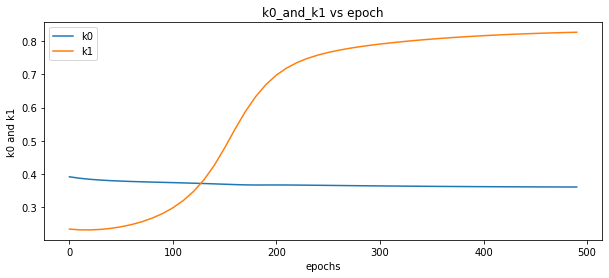

In [38]:
fig = plt.figure(figsize=(10,4))
epochs = list(range(0,500, 10))
plt.plot(epochs,k0_lst,label='k0')
plt.plot(epochs,k1_lst,label='k1')
plt.xlabel('epochs')
plt.ylabel('k0 and k1')
plt.title("k0_and_k1 vs epoch")
plt.legend()

#### **Final values for parameters k0 and k1.**

In [39]:
print("k0:", k0)
print("k1:", k1)

k0: [0.36077743]
k1: [0.82785261]


In [40]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, k0, k1):
  Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, k0, k1, X)
  predict_labels = get_predictions(A3)
  return predict_labels

**F1-Score.**

In [41]:
prdicted_labels = make_predictions(test_data, W1, b1, W2, b2, W3, b3, k0, k1)
ture_labels = test_labels
print(f1_score(ture_labels, prdicted_labels, average='weighted'))

0.8465566678080639
